## Notes:
- The parallelization has changed its interface, now it is using `joblib` library by specifying a `n_jobs` parameter in ,`GWR()` or `MGWR()` and `Sel_BW()`.

- `mgwr` has soft dependency of `numba`, please install numba if you need better performance (`pip install numba`).

In [1]:
import numpy as np
import geopandas as gp
import multiprocessing as mp
import libpysal as ps
import sys

sys.path.append('/Users/ziqili/Desktop/mgwr-2')
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [2]:
#Load Berlin example
prenz = gp.read_file(ps.examples.get_path('prenzlauer.zip'))

In [3]:
b_y = np.log(prenz['price'].values.reshape((-1, 1)))
b_X = prenz[['review_sco','accommodat','bathrooms']].values 
b_X = (b_X - b_X.mean(axis=0)) / b_X.std(axis=0)
b_y = (b_y - b_y.mean(axis=0)) / b_y.std(axis=0)
u = prenz['X']
v = prenz['Y']
b_coords = list(zip(u, v))

### GWR No Parallel (n_jobs=1)

In [4]:
%%time
gwr_selector = Sel_BW(b_coords, b_y, b_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)
gwr_results = GWR(b_coords, b_y, b_X, gwr_bw,n_jobs=1).fit() #n_jobs

192.0
CPU times: user 56.2 s, sys: 1.22 s, total: 57.4 s
Wall time: 5.38 s


### MGWR No Parallel (n_jobs=1)

In [5]:
%%time
mgwr_selector = Sel_BW(b_coords, b_y, b_X, multi=True,n_jobs=1)
mgwr_bw = mgwr_selector.search()
print(mgwr_bw)
mgwr_results = MGWR(b_coords, b_y, b_X, selector=mgwr_selector,n_jobs=1).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 191. 1279.   79. 2200.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 15min 37s, sys: 51 s, total: 16min 28s
Wall time: 1min 24s


### GWR Parallel

In [6]:
#n_jobs = 2 #two processors
n_jobs = -1 #all processors

In [7]:
%%time
gwr_selector = Sel_BW(b_coords, b_y, b_X,n_jobs=n_jobs) #add n_jobs to Sel_BW()
gwr_bw = gwr_selector.search() #add pool to Sel_BW.search
print(gwr_bw)
gwr_results = GWR(b_coords, b_y, b_X, gwr_bw,n_jobs=n_jobs).fit() #add n_jobs to GWR()

192.0
CPU times: user 1.34 s, sys: 403 ms, total: 1.74 s
Wall time: 3.6 s


## Effectiveness of `n_jobs`
Note: The plots are for demonstration purposes only and are based on a specific dataset and a specific machine (12-core). Actual scalability may vary.

Text(0.5, 1.0, 'GWR Performance with Different n_jobs Values')

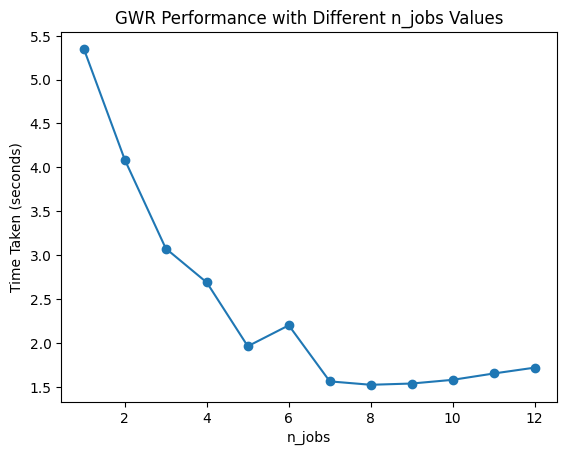

In [8]:
from time import time
import matplotlib.pyplot as plt

n_jobs_values = np.arange(1,13)
performance_times_avg = []

for n_jobs in n_jobs_values:
    times = []
    for _ in range(5): 
        start_time = time()

        gwr_selector = Sel_BW(b_coords, b_y, b_X,n_jobs=n_jobs) #n_jobs
        gwr_bw = gwr_selector.search()
        gwr_results = GWR(b_coords, b_y, b_X, gwr_bw,n_jobs=n_jobs).fit() #n_jobs

        end_time = time()
        times.append(end_time - start_time)
    average_time = sum(times) / len(times)
    performance_times_avg.append(average_time)

# Plotting the results
plt.plot(n_jobs_values, performance_times_avg,marker='o')
plt.xlabel('n_jobs')
plt.ylabel('Time Taken (seconds)')
plt.title('GWR Performance with Different n_jobs Values')

### MGWR Parallel

In [9]:
%%time
mgwr_selector = Sel_BW(b_coords, b_y, b_X, multi=True,n_jobs=n_jobs) #add n_jobs to MGWR()
mgwr_bw = mgwr_selector.search()
print(mgwr_bw)
mgwr_results = MGWR(b_coords, b_y, b_X, selector=mgwr_selector,n_jobs=n_jobs).fit() #add n_jobs to MGWR()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[ 191. 1279.   79. 2200.]


Inference:   0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 27.2 s, sys: 6.47 s, total: 33.7 s
Wall time: 34.2 s


In [11]:
from time import time
import matplotlib.pyplot as plt

n_jobs_values = np.arange(1,13)
performance_times_avg = []

for n_jobs in n_jobs_values:
    times = []
    for _ in range(5): 
        start_time = time()

        mgwr_selector = Sel_BW(b_coords, b_y, b_X, multi=True,n_jobs=n_jobs) #add n_jobs
        mgwr_bw = mgwr_selector.search()
        mgwr_results = MGWR(b_coords, b_y, b_X, selector=mgwr_selector,n_jobs=n_jobs).fit() #add n_jobs

        end_time = time()
        times.append(end_time - start_time)
    average_time = sum(times) / len(times)
    performance_times_avg.append(average_time)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/2 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/3 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/4 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/5 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/5 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/5 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/5 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/6 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/6 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/6 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/6 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/6 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/7 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/7 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/7 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/7 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/7 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/8 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/8 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/8 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/8 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/8 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/9 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/9 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/9 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/9 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/9 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/10 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/10 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/10 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/10 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/10 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/11 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/11 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/11 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/11 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/11 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/12 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/12 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/12 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/12 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/12 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MGWR Performance with Different n_jobs Values')

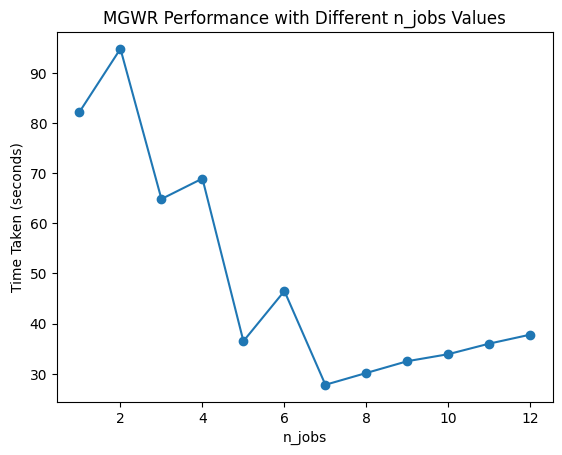

In [12]:
# Plotting the results
plt.plot(n_jobs_values, performance_times_avg,marker='o')
plt.xlabel('n_jobs')
plt.ylabel('Time Taken (seconds)')
plt.title('MGWR Performance with Different n_jobs Values')